In [14]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

from util.preprocess import preprocess
from util.geo_data import add_geo_data

In [2]:
df_original = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

# Preprocess

In [3]:
df_processed = preprocess(df_original)
df_processed = add_geo_data(df_processed)

In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   MONTH                     162691 non-null  object 
 1   TOWN                      162691 non-null  object 
 2   FLAT_TYPE                 162691 non-null  object 
 3   BLOCK                     162691 non-null  object 
 4   STREET                    162691 non-null  object 
 5   FLOOR_RANGE               162691 non-null  object 
 6   FLOOR_AREA_SQM            162691 non-null  float64
 7   FLAT_MODEL                162691 non-null  object 
 8   LEASE_COMMENCE_DATA       162691 non-null  int64  
 9   RESALE_PRICE              162691 non-null  float64
 10  RESALE_YEAR               162691 non-null  int64  
 11  RESALE_MONTH              162691 non-null  int64  
 12  FLAT_AGE                  162691 non-null  int64  
 13  FLOOR_AVG                 162691 non-null  i

In [5]:
df_processed.to_csv("output.csv", index=False)

In [6]:
target_col = 'RESALE_PRICE'
categorical_features = ['TOWN', 'FLAT_TYPE',  'FLAT_MODEL']
numerical_features = ['FLOOR_AREA_SQM', 'RESALE_YEAR', 'RESALE_MONTH', 
                      'FLAT_AGE', 'FLOOR_AVG', 'DIST_TO_NEAREST_MRT_M', 
                      'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M']
# categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
# numeric_cols = [c for c in X.columns if c not in categorical_cols]

In [7]:
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Split Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

In [9]:
preprocess_ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# SVM Model

In [10]:
svr = SVR(kernel="rbf")

# Log-transform target to help SVR on skewed price distributions
# log1p = FunctionTransformer(np.log1p, validate=False)
# expm1 = FunctionTransformer(np.expm1, validate=False)
log1p_expm1 = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False)

model = Pipeline(steps=[
    ("prep", preprocess_ct),
    ("svr_ttr", TransformedTargetRegressor(
        regressor=svr,
        transformer=log1p_expm1,
    ))
])

# Hyperparameter Grid Search

In [11]:
param_grid = {
    "svr_ttr__regressor__C": [3, 10],
    "svr_ttr__regressor__epsilon": [0.1],
    "svr_ttr__regressor__gamma": ["scale", 0.03]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gscv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # MAE is robust for prices
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

gscv.fit(X_train, y_train)

print("\nBest CV MAE:", -gscv.best_score_)
print("Best Params:", gscv.best_params_)

best_model = gscv.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits



Best CV MAE: 23759.112018143212
Best Params: {'svr_ttr__regressor__C': 3, 'svr_ttr__regressor__epsilon': 0.1, 'svr_ttr__regressor__gamma': 'scale'}


# Evaluation

In [15]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Test Metrics ===")
print(f"MAE : {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²  : {r2:.4f}")


=== Test Metrics ===
MAE : 23,526
RMSE: 32,077
R²  : 0.9692


# Save Best Model

In [19]:
from joblib import dump, load

# save model
dump(best_model, "svr_hdb_model.joblib")

# load model
model = load("svr_hdb_model.joblib")

# Visualization

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

import os

# Create folder (only once)
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

In [51]:
# Build an evaluation DataFrame to group/plot easily
df_eval = pd.DataFrame(index=range(len(y_test)))
df_eval["actual"] = np.asarray(y_test)
df_eval["pred"]   = np.asarray(y_pred)
df_eval["residual"] = df_eval["actual"] - df_eval["pred"]
df_eval["abs_error"] = df_eval["residual"].abs()

for col in ["TOWN", "FLAT_TYPE", "RESALE_YEAR"]:
    if col in X_test.columns:
        df_eval[col] = X_test[col]

print(df_eval.columns)


Index(['actual', 'pred', 'residual', 'abs_error', 'TOWN', 'FLAT_TYPE',
       'RESALE_YEAR'],
      dtype='object')


In [71]:
df_eval = X_test.copy()
df_eval["actual"] = y_test
df_eval["pred"]   = y_pred
df_eval["residual"] = df_eval["actual"] - df_eval["pred"]
df_eval["abs_error"]= df_eval["residual"].abs()

## Actual vs Predicted Prices
The red dashed line = perfect prediction.
Points close to it = good fit.
If high-price flats fall below the line → model underpredicts expensive flats.
If pattern bends → model might not capture nonlinearities perfectly.

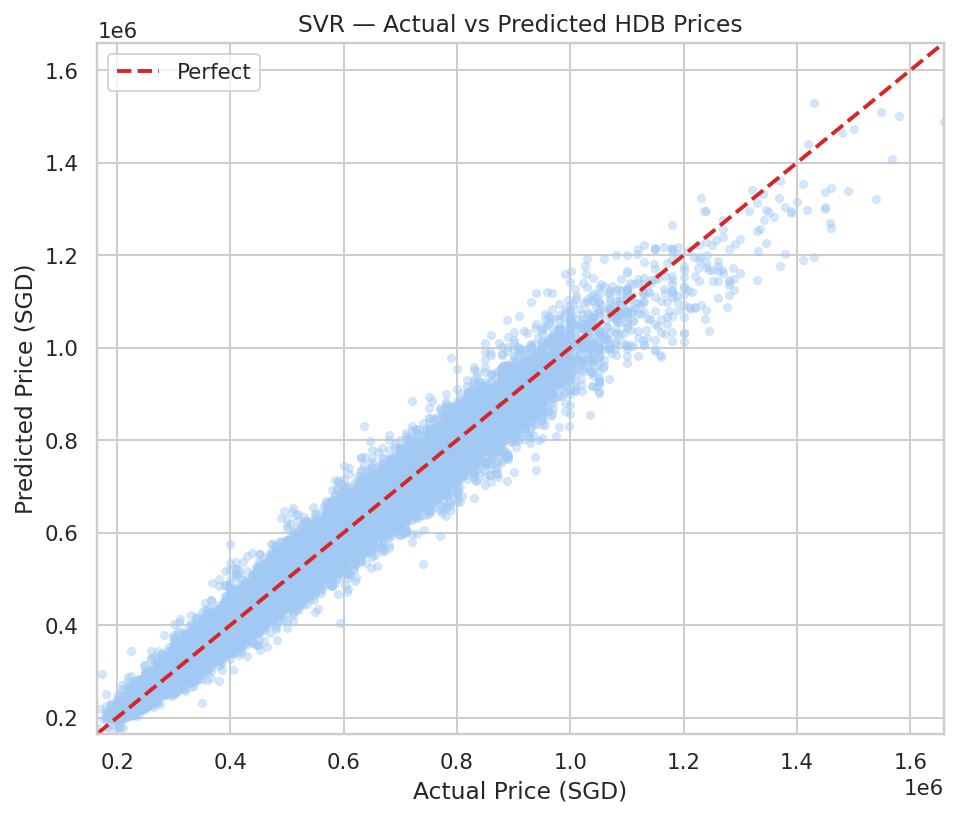

In [72]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df_eval,
    x="actual", y="pred", s=18, alpha=0.45, edgecolor=None
)
lims = [df_eval[["actual","pred"]].min().min(), df_eval[["actual","pred"]].max().max()]
plt.plot(lims, lims, linestyle="--", linewidth=2, color="tab:red", label="Perfect")
plt.xlim(lims); plt.ylim(lims)
plt.title("SVR — Actual vs Predicted HDB Prices")
plt.xlabel("Actual Price (SGD)")
plt.ylabel("Predicted Price (SGD)")
plt.legend()
plt.tight_layout()
plt.savefig('plots/svr_actual_vs_predicted_hdb_prices.png', bbox_inches='tight', dpi=300)
plt.show()

## Distribution of Actual and Predicted

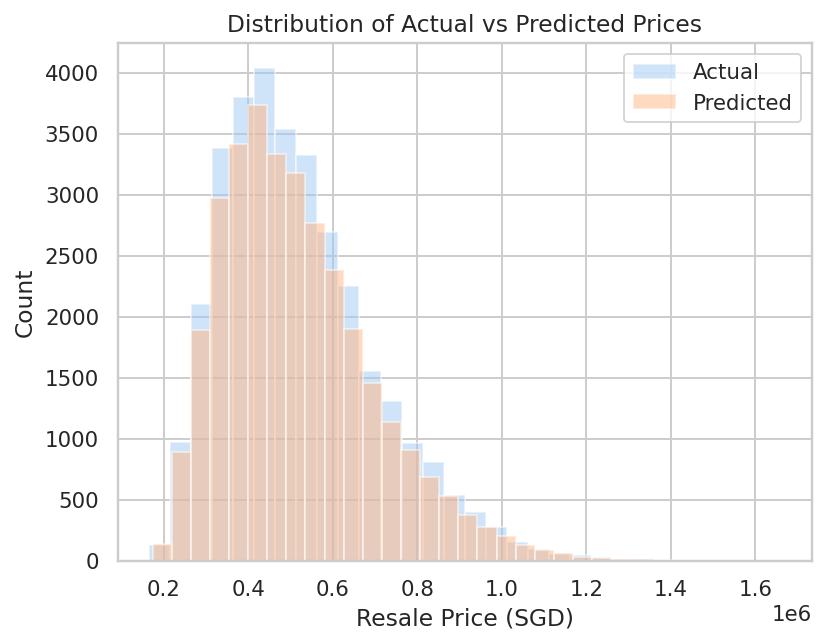

In [67]:
plt.hist(y_test, bins=30, alpha=0.5, label='Actual')
plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted')
plt.legend()
plt.title("Distribution of Actual vs Predicted Prices")
plt.xlabel("Resale Price (SGD)"); plt.ylabel("Count")
plt.savefig('plots/svr_distribution_actual_vs_predicted_hdb_prices.png', bbox_inches='tight', dpi=300)
plt.show()

## Residual Plot
If residuals curve (e.g., ↑ for high predicted values), model is biased for certain price ranges.
Funnel shape → heteroscedasticity (variance grows with price).

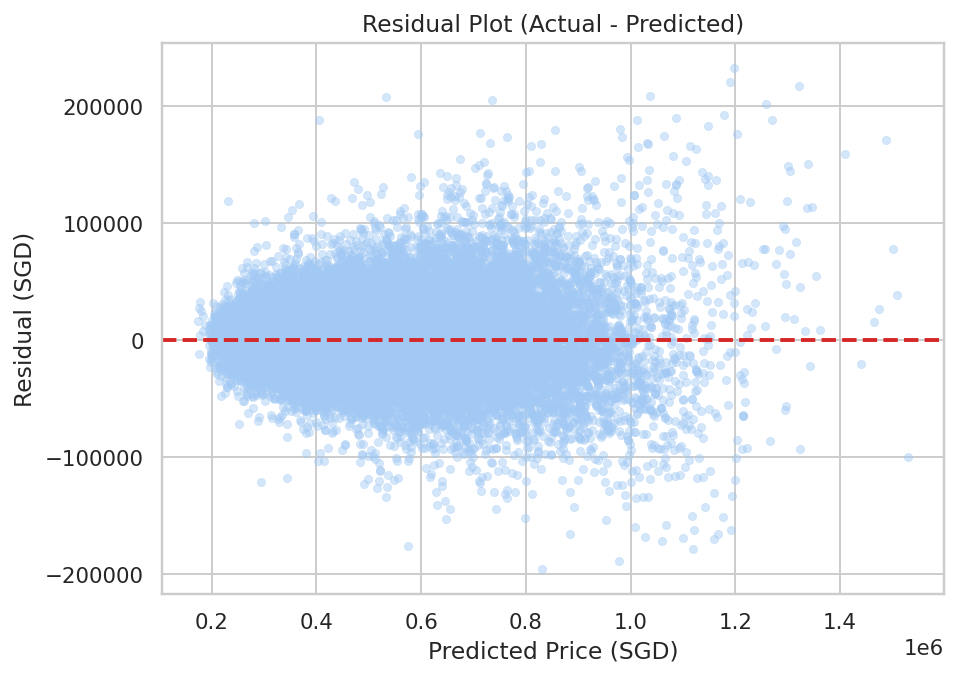

In [74]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_eval,   
    x="pred",
    y="residual",
    s=18,            # point size
    alpha=0.45,      # transparency
    edgecolor=None   # no black outlines
)
plt.axhline(0, ls="--", lw=2, color="tab:red")
plt.title("Residual Plot (Actual - Predicted)")
plt.xlabel("Predicted Price (SGD)"); plt.ylabel("Residual (SGD)")
plt.tight_layout()
plt.savefig('plots/svr_residual_plot.png', bbox_inches='tight', dpi=300)
plt.show()

## Error by Town
Spot areas (e.g., Bukit Timah, Bishan) where model struggles — maybe fewer samples or outliers.

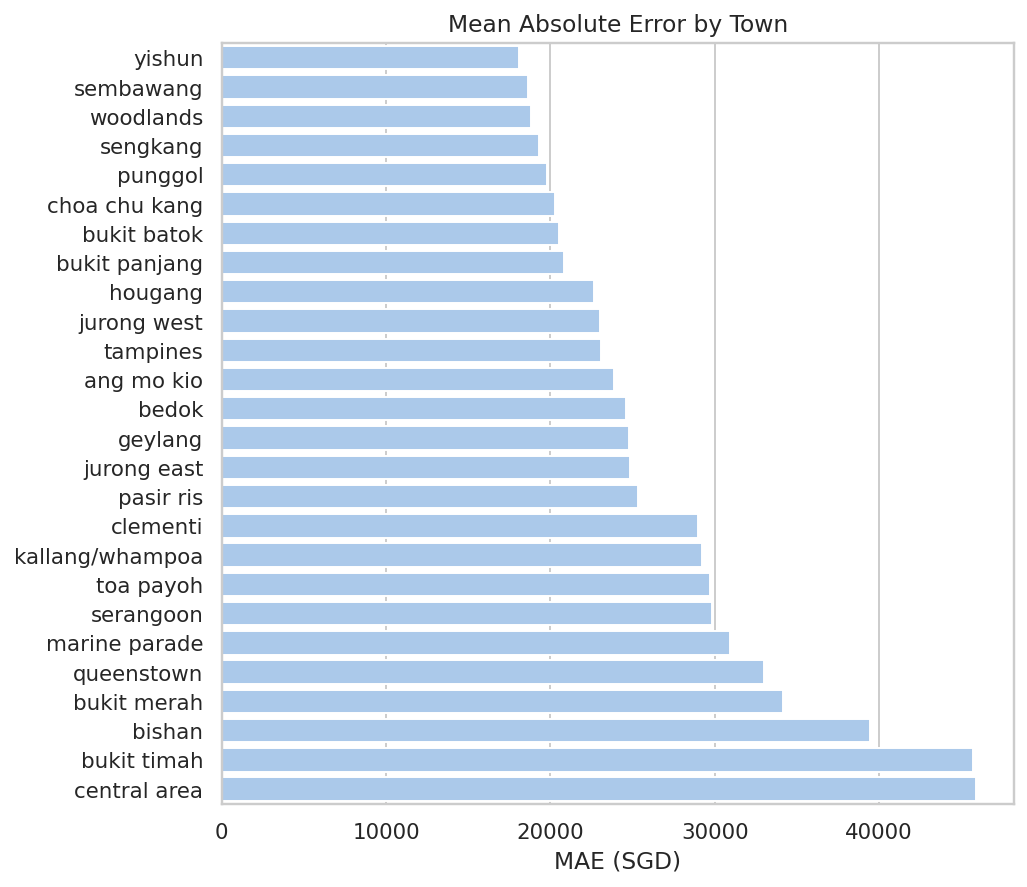

In [75]:
town_mae = df_eval.groupby("TOWN")["abs_error"].mean().sort_values()
plt.figure(figsize=(7.5, max(3, 0.25*len(town_mae))))
sns.barplot(x=town_mae.values, y=town_mae.index, orient="h")
plt.title("Mean Absolute Error by Town")
plt.xlabel("MAE (SGD)"); plt.ylabel("")
plt.tight_layout()
plt.savefig('plots/svr_mae_by_town.png', bbox_inches='tight', dpi=300)
plt.show()

## MAE by Year
If error suddenly spikes in newer year → model doesn’t generalize forward well (time-based retraining needed).

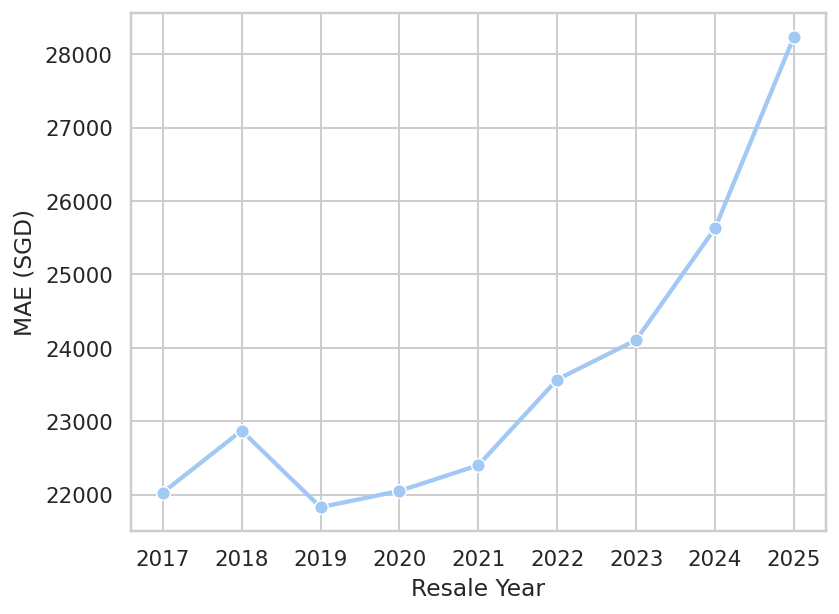

In [78]:
mae_by_year = (
    df_eval.groupby("RESALE_YEAR", as_index=False)["abs_error"].mean()
    .rename(columns={"RESALE_YEAR": "Resale Year"})
)

sns.lineplot(
    data=mae_by_year,
    x="Resale Year",
    y="abs_error",
    marker="o",
    linewidth=2.2,
    markersize=7
)
plt.ylabel("MAE (SGD)")
plt.savefig('plots/svr_mae_by_year.png', bbox_inches='tight', dpi=300)
plt.show()